### Imports

In [1]:
import cv2
import time

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from helpers.limbus_detection import detect_circle, detect_pupil_thresh
from helpers.misc import \
    jiggle_circle, tighten_circle, repair_bbox, is_circle_enclosed, geometric_median
from helpers.view_detection import get_view_mask

%load_ext autoreload
%autoreload 2

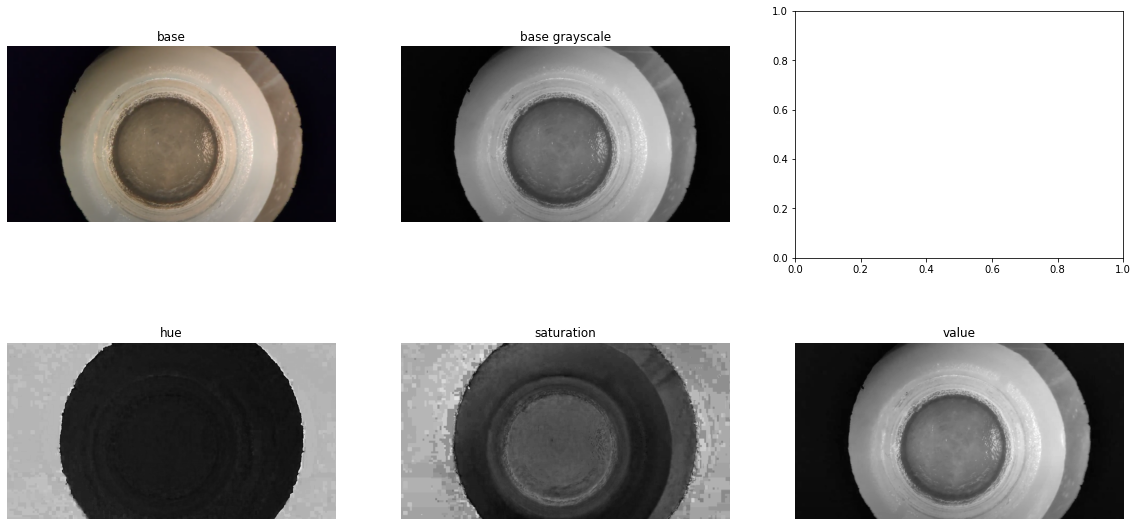

size: 1441x773


In [18]:
# scale = 0.33
scale = 1.0

base = cv2.imread('data/artificial/bioniko_rhexis_base8.png', cv2.IMREAD_COLOR)
base = cv2.resize(base, (0,0), fx=scale, fy=scale)

base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:,:,0]
base_saturation = base_hsv[:,:,1]
base_value = base_hsv[:,:,2]

fig, ((plot1, plot2, _), (plot3, plot4, plot5)) = plt.subplots(2, 3, figsize=(20,10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

print('size: %dx%d' % (base.shape[1], base.shape[0]))

### Color selection by mouse clicking

selected points: [(524, 354), (689, 336), (691, 429), (845, 454), (716, 597)]


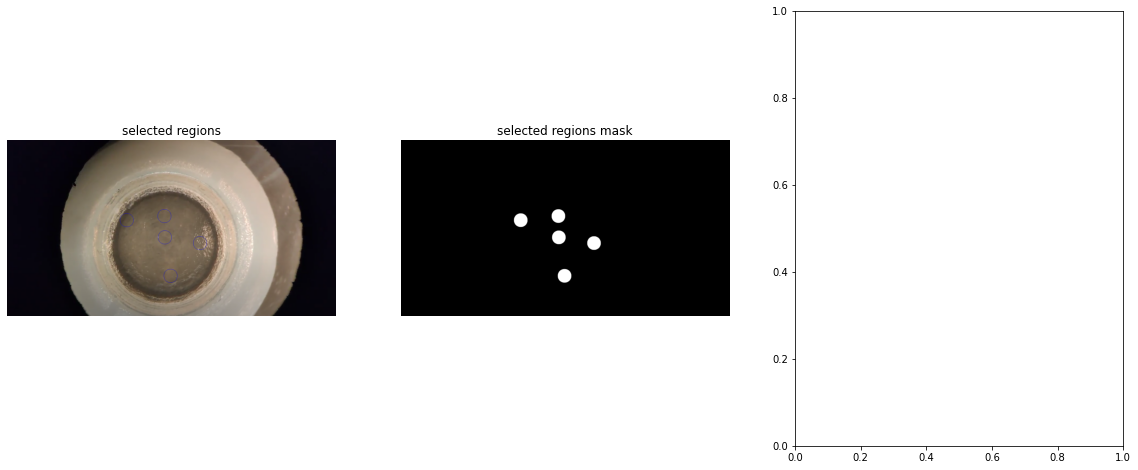

In [19]:
SELECTION_RADIUS = 30

points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONUP:
        points.append((x, y))
        
window_name = 'point selection'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, mouse_callback)
cv2.imshow(window_name, base)

ip = cv2.waitKey(0) & 0xFF
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)
        
print('selected points: %s' % str(points))
        
# visualization
base_rgb_copy = base_rgb.copy()
selection_mask = np.zeros(base_rgb.shape[:2], dtype=np.uint8)
for point in points:
    cv2.circle(base_rgb_copy, point, SELECTION_RADIUS, (0,0,255))
    cv2.circle(selection_mask, point, SELECTION_RADIUS, 255, cv2.FILLED)

fig, plots = plt.subplots(1, 3, figsize=(20,8))
plots[0].set_title('selected regions')
plots[0].imshow(base_rgb_copy)
plots[0].axis('off')

plots[1].set_title('selected regions mask')
plots[1].imshow(selection_mask, cmap='gray')
plots[1].axis('off')

plt.show()

histogram computation

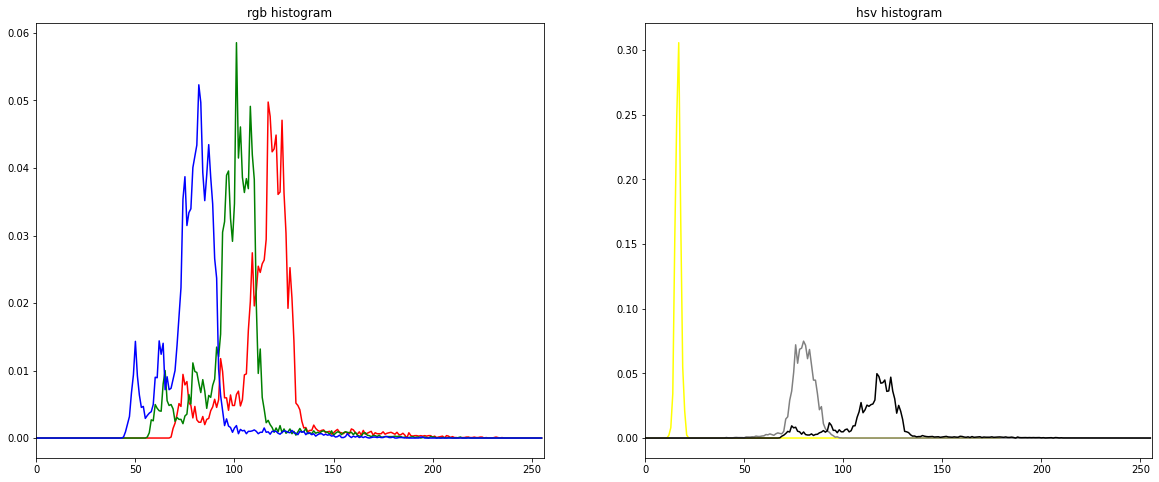

In [20]:
hist_r = cv2.calcHist([base_rgb], [0], selection_mask, [256], [0,256])
hist_r /= hist_r.sum()
hist_g = cv2.calcHist([base_rgb], [1], selection_mask, [256], [0,256])
hist_g /= hist_g.sum()
hist_b = cv2.calcHist([base_rgb], [2], selection_mask, [256], [0,256])
hist_b /= hist_b.sum()

hist_h = cv2.calcHist([base_hsv], [0], selection_mask, [180], [0,180])
hist_h /= hist_h.sum()
hist_s = cv2.calcHist([base_hsv], [1], selection_mask, [256], [0,256])
hist_s /= hist_s.sum()
hist_v = cv2.calcHist([base_hsv], [2], selection_mask, [256], [0,256])
hist_v /= hist_v.sum()

fig, plots = plt.subplots(1, 2, figsize=(20,8))
plots[0].set_title('rgb histogram')
plots[0].plot(hist_r, color='red')
plots[0].plot(hist_g, color='green')
plots[0].plot(hist_b, color='blue')
plots[0].set_xlim([0,256])

plots[1].set_title('hsv histogram')
plots[1].plot(hist_h, color='yellow')
plots[1].plot(hist_s, color='grey')
plots[1].plot(hist_v, color='black')
plots[1].set_xlim([0,256])

plt.show()

histogram back projection

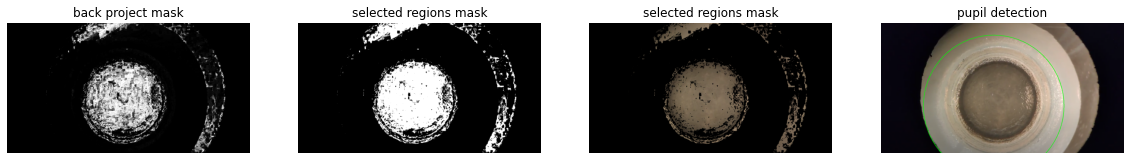

In [21]:
hist_hs = cv2.calcHist([base_hsv], [0,1], selection_mask, [180,256], [0,180,0,256])
back_project = cv2.calcBackProject([base_hsv], [0, 1], hist_hs, [0, 180, 0, 256], 1)

_, back_project_mask = cv2.threshold(back_project, 20, 255, cv2.THRESH_BINARY)
base_rgb_copy = base_rgb.copy()
base_rgb_copy[back_project_mask == 0] = [0,0,0]

base_rgb_copy2 = base_rgb.copy()
circle = detect_pupil_thresh(back_project_mask, pca_correction=True)
cv2.circle(base_rgb_copy2, tuple(circle[:2].round().astype(np.int64)), round(circle[2]), (0,255,0), 2)      

fig, plots = plt.subplots(1, 4, figsize=(20,8))
plots[0].set_title('back project mask')
plots[0].imshow(back_project, cmap='gray')
plots[0].axis('off')

plots[1].set_title('selected regions mask')
plots[1].imshow(back_project_mask, cmap='gray')
plots[1].axis('off')

plots[2].set_title('selected regions mask')
plots[2].imshow(base_rgb_copy)
plots[2].axis('off')

plots[3].set_title('pupil detection')
plots[3].imshow(base_rgb_copy2)
plots[3].axis('off')

plt.show()

connected components used to remove unwanted structures

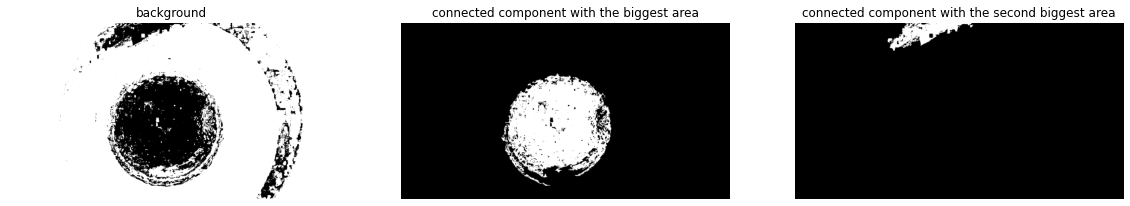

In [23]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(back_project_mask)
biggest_area_labels = np.flip(np.argsort(stats[:,4]))

labels_background = labels.copy()
labels_background[labels != 0] = 0
labels_background[labels == 0] = 255

labels_prominent1 = labels.copy()
labels_prominent1[labels != biggest_area_labels[1]] = 0
labels_prominent1[labels == biggest_area_labels[1]] = 255

labels_prominent2 = labels.copy()
labels_prominent2[labels != biggest_area_labels[2]] = 0
labels_prominent2[labels == biggest_area_labels[2]] = 255

fig, plots = plt.subplots(1, 3, figsize=(20,8))
plots[0].set_title('background')
plots[0].imshow(labels_background , cmap='gray')
plots[0].axis('off')

plots[1].set_title('connected component with the biggest area')
plots[1].imshow(labels_prominent1, cmap='gray')
plots[1].axis('off')

plots[2].set_title('connected component with the second biggest area')
plots[2].imshow(labels_prominent2, cmap='gray')
plots[2].axis('off')

plt.show()
